# Introduction

The purpose of this project is to analyze nighttime aircraft noise complaints around San Francisco International Airport (SFO) to understand which neighborhoods are most affected. Specifically, we aim to:

Identify neighborhoods with the highest number of night-time complaints (8 PM–7 AM).

Examine how factors such as aircraft type, altitude, and operation type influence complaint patterns.

Build a predictive model to estimate future complaint levels and test how changes in flight operations could reduce noise.

By cleaning, analyzing, and modeling aircraft noise data from SFO, this project seeks to uncover meaningful insights that can help both residents and airport authorities address nighttime noise disturbances.

# Data Source

The dataset used in this project is the San Francisco International Airport (SFO) Aircraft Noise Reports, obtained from Data.gov :  https://catalog.data.gov/dataset/sfo-aircraft-noise-reports
. It contains aircraft noise complaints recorded by residents near SFO from 2018 to the present.

For this analysis, we focus only on night-time reports (8 PM–7 AM). The dataset includes variables such as disturbance date and time, reporter city and postal code, aircraft altitude, aircraft type, operation type, and airport ID, hour. Some cleaning was performed to remove missing values, filter SFO records, and ensure data consistency.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [5]:
# Download latest version of your dataset
df = pd.read_csv("../data/Aircraft_Noise_Reports.csv")

# inspect dataset
df.head()


/var/folders/sc/pdyvxd7s6yg_4vmwpgn89ld80000gn/T/ipykernel_14850/1413754666.py:2: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/Aircraft_Noise_Reports.csv")


,disturbance_date_time,report_method,corr_id,reporter_city,reporter_postal_code,aircraft_pca_altitude,airport_id,operation_type,runway_name,flight_no,aircraft_type,destination_origin,data_as_of,data_loaded_at
0,2024/08/18 07:21:21 PM,Email,20662792,Palo Alto,94301,4911.0,SFO,A,28L,AAL2165,A319,LAX,2024/09/26 11:38:51 AM,2025/10/07 06:22:50 AM
1,2024/08/18 07:21:42 PM,AWA App,20662333,Portola Valley,94028,4610.0,SFO,A,28L,ASA129,B739,LAS,2024/09/26 11:38:51 AM,2025/10/07 06:22:50 AM
2,2024/08/18 07:21:46 PM,AWA App,20662792,Palo Alto,94303,4803.0,SFO,A,28L,AAL2165,A319,LAX,2024/09/26 11:38:51 AM,2025/10/07 06:22:50 AM
3,2024/08/18 07:24:40 PM,AWA App,20663178,Redwood City,94061,4390.0,SFO,A,28R,UAL1947,B39M,HNL,2024/09/26 11:38:51 AM,2025/10/07 06:22:50 AM
4,2024/09/13 07:09:59 PM,AWA App,20692087,Santa Cruz,95065,11378.0,SFO,A,28L,UAL2320,B739,LAX,2024/11/07 05:04:54 PM,2025/10/07 06:22:50 AM


# Clean and Prepare Data

In [6]:

# Load only needed columns from the CSV to save memory
columns_to_load = [
    'disturbance_date_time', 'reporter_city', 'reporter_postal_code',
    'aircraft_pca_altitude', 'airport_id', 'operation_type', 'aircraft_type'
]


In [7]:

# Step 1: Drop rows with missing values in essential columns first
essential_columns = ['disturbance_date_time', 'reporter_postal_code', 'airport_id', 'operation_type']
df = df.dropna(subset=essential_columns)


In [8]:

# Step 2: Filter for SFO airport and operation type (Arrival/Departure)
df = df[(df['airport_id'] == 'SFO') & (df['operation_type'].isin(['A', 'D']))]


In [9]:

# Step 3: Convert disturbance_date_time to datetime (after dropping nulls to save time)

df['disturbance_date_time'] = pd.to_datetime(
    df['disturbance_date_time'],
    format="%Y/%m/%d %I:%M:%S %p",  # note %I for 12-hour and %p for AM/PM
    errors='coerce'
)


In [10]:

# Step 4: Drop rows where conversion failed (NaT values)
df = df.dropna(subset=['disturbance_date_time'])


In [11]:

# Step 5: Extract hour for night-time filtering
df['hour'] = df['disturbance_date_time'].dt.hour


In [12]:

# Step 6: Filter for night-time complaints (8 PM - 7 AM)
df = df[(df['hour'] >= 20) | (df['hour'] <= 7)]

# Remove duplicates
df = df.drop_duplicates()

# Step 7: Reset index
df = df.reset_index(drop=True)


In [13]:
# keep only the needed columns
columns_needed = [
    'disturbance_date_time', 'reporter_city', 'reporter_postal_code',
    'aircraft_pca_altitude', 'airport_id', 'operation_type', 'aircraft_type', 'hour'
]

df = df[columns_needed]

In [14]:
# Save the cleaned dataset
df.to_csv("../data/Cleaned_Aircraft_Noise_Night_SFO.csv", index=False)

print("Cleaned dataset saved to data/Cleaned_Aircraft_Noise_Night_SFO.csv")

Cleaned dataset saved to data/Cleaned_Aircraft_Noise_Night_SFO.csv


In [15]:
df.head()

,disturbance_date_time,reporter_city,reporter_postal_code,aircraft_pca_altitude,airport_id,operation_type,aircraft_type,hour
0,2024-08-18 20:03:17,Portola Valley,94028,5007.0,SFO,D,B77W,20
1,2024-08-18 20:13:19,Los Altos Hills,94024,6644.0,SFO,A,E75L,20
2,2024-08-18 20:12:53,Mountain View,94040,6296.0,SFO,A,E75L,20
3,2024-08-18 20:10:30,San Francisco,94124,4678.0,SFO,D,B738,20
4,2024-08-18 20:15:16,Mountain View,94040,6296.0,SFO,A,E75L,20


# Exploratory Data Analysis

Count complaints by city 

In [18]:
complaints_by_city = (
    df.groupby('reporter_city').size().reset_index(name='complaint_count')
)
complaints_by_city = complaints_by_city.sort_values(by='complaint_count', ascending=False)

complaints_by_city.head(10)

,reporter_city,complaint_count
46,Palo Alto,539153
50,Portola Valley,277261
60,Santa Cruz,217696
33,Los Altos,207734
62,Scotts Valley,110485
64,Soquel,100524
35,Los Gatos,79328
41,Mountain View,57824
34,Los Altos Hills,52609
55,San Francisco,49004


Bar plot shows the top 15 most affected neighborhoods

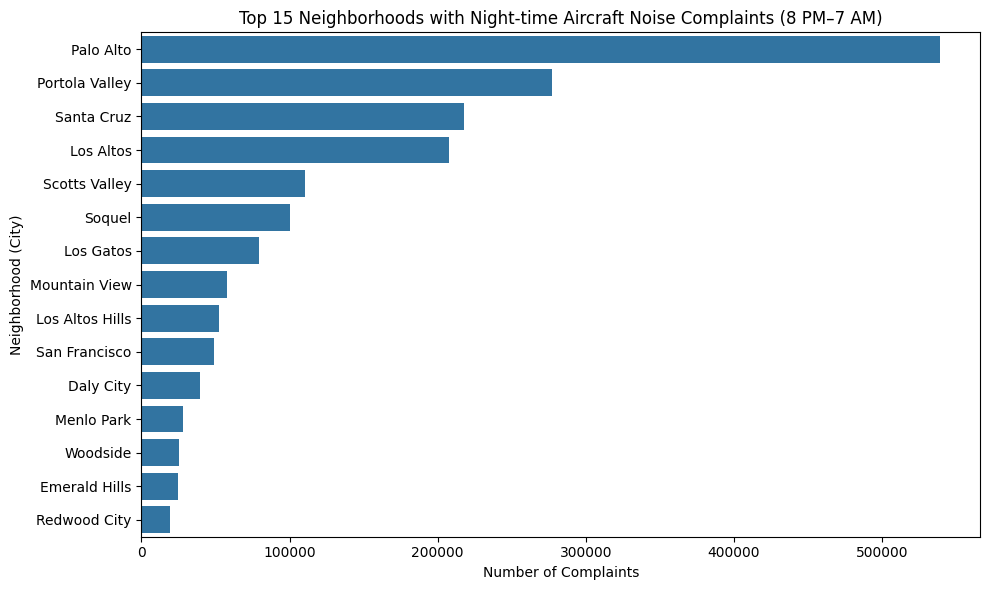

In [19]:
plt.figure(figsize=(10,6))
sns.barplot(
    data=complaints_by_city.head(15),
    x="complaint_count",
    y="reporter_city"
)
plt.title("Top 15 Neighborhoods with Night-time Aircraft Noise Complaints (8 PM–7 AM)")
plt.xlabel("Number of Complaints")
plt.ylabel("Neighborhood (City)")
plt.tight_layout()
plt.show()


We will create new column that shows how much the distance from each of these neighborhood are from SFO, then we could give stronger support to the findings.

For now, the answers show Palo Alto has the most complaints. Redwood city has the lowest.

Next we will find contributing factor to this. (Altitude)

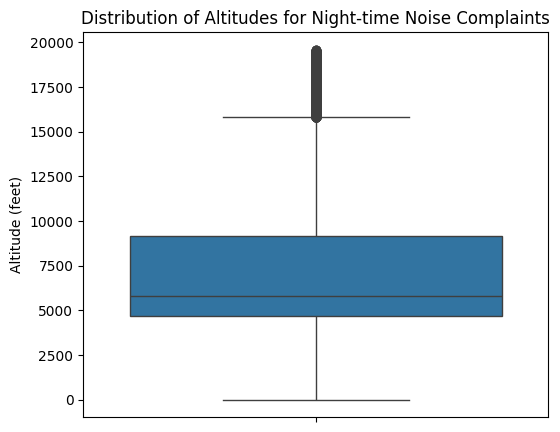

In [21]:
df_alt = df.dropna(subset=['aircraft_pca_altitude'])
df_alt = df_alt[df_alt['aircraft_pca_altitude'] > 0]

plt.figure(figsize=(6,5))
sns.boxplot(data=df_alt, y="aircraft_pca_altitude")
plt.title("Distribution of Altitudes for Night-time Noise Complaints")
plt.ylabel("Altitude (feet)")
plt.show()


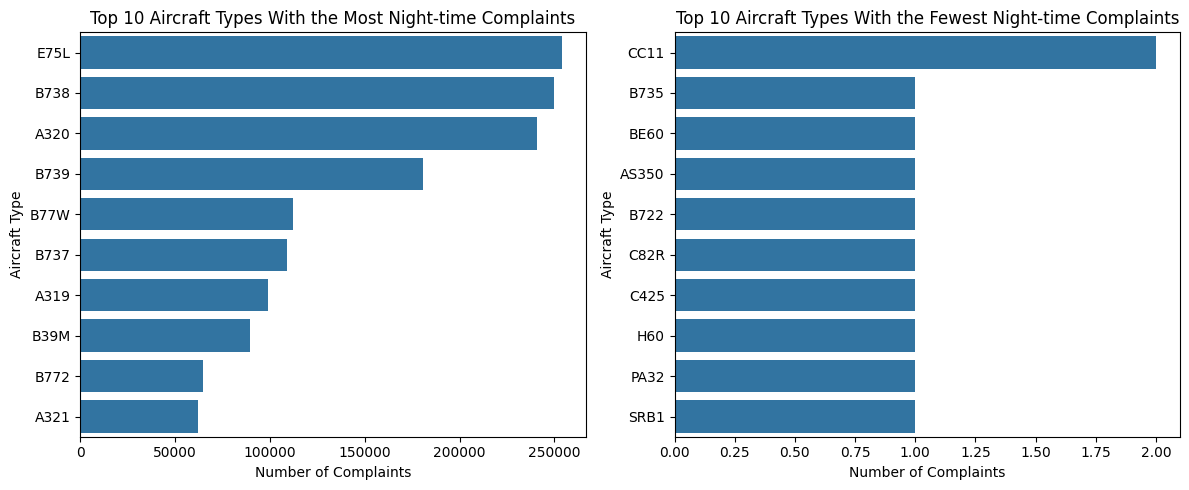

In [32]:
# Count complaints by aircraft type
complaints_by_aircraft = (
    df.groupby('aircraft_type')
      .size()
      .reset_index(name='num_complaints')
      .sort_values(by='num_complaints', ascending=False)
)

complaints_by_aircraft.head()

# Take top 15 aircraft types by number of complaints
top10_high = complaints_by_aircraft.head(10)
top10_low = complaints_by_aircraft.tail(10)


plt.figure(figsize=(12,5))

# Top 10 highest
plt.subplot(1,2,1)
sns.barplot(data=top10_high, x='num_complaints', y='aircraft_type')
plt.title("Top 10 Aircraft Types With the Most Night-time Complaints")
plt.xlabel("Number of Complaints")
plt.ylabel("Aircraft Type")

# Top 10 lowest
plt.subplot(1,2,2)
sns.barplot(data=top10_low, x='num_complaints', y='aircraft_type')
plt.title("Top 10 Aircraft Types With the Fewest Night-time Complaints")
plt.xlabel("Number of Complaints")
plt.ylabel("Aircraft Type")

plt.tight_layout()
plt.show()





TIME AT NIGHT THAT GENERATE THE MOST AND LEAST COMPLAINT

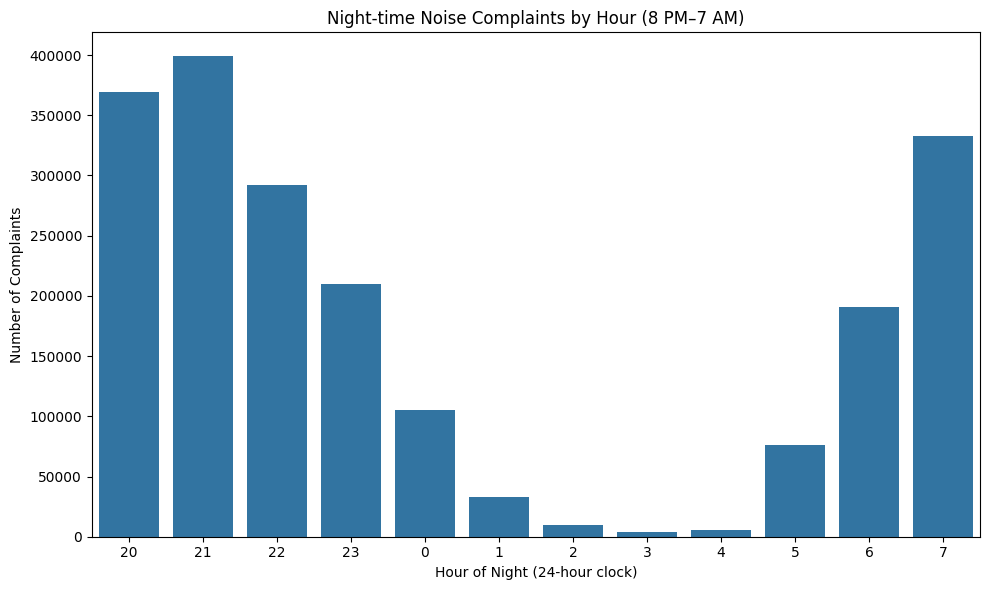

Hour with MOST complaints: 21 with 398915 complaints
Hour with LEAST complaints: 3 with 3795 complaints


In [34]:
# Count complaints for each hour in the night period
# Define the night hours in order
night_hours = [20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6, 7]

# Make 'hour' a categorical variable with this order
complaints_by_hour['hour'] = pd.Categorical(
    complaints_by_hour['hour'],
    categories=night_hours,
    ordered=True
)

plt.figure(figsize=(10,6))
sns.barplot(data=complaints_by_hour, x='hour', y='num_complaints')
plt.title("Night-time Noise Complaints by Hour (8 PM–7 AM)")
plt.xlabel("Hour of Night (24-hour clock)")
plt.ylabel("Number of Complaints")
plt.tight_layout()
plt.show()

most = complaints_by_hour.loc[complaints_by_hour['num_complaints'].idxmax()]
least = complaints_by_hour.loc[complaints_by_hour['num_complaints'].idxmin()]

print("Hour with MOST complaints:", int(most['hour']), "with", int(most['num_complaints']), "complaints")
print("Hour with LEAST complaints:", int(least['hour']), "with", int(least['num_complaints']), "complaints")


TIME OF YEAR SEASONAL COMPLAINT

In [40]:
# Count complaints by season
complaints_by_season = df['season'].value_counts().reindex(['Winter','Spring','Summer','Fall'])



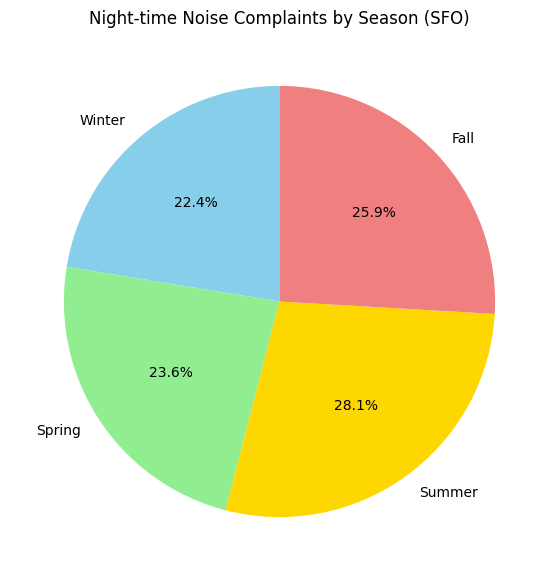

In [41]:
plt.figure(figsize=(7,7))
plt.pie(
    complaints_by_season,
    labels=complaints_by_season.index,
    autopct='%1.1f%%',  # show percentages
    colors=['skyblue','lightgreen','gold','lightcoral'],
    startangle=90
)
plt.title("Night-time Noise Complaints by Season (SFO)")
plt.show()



COUNT COMPLAINTS BY OPERATION TYPE

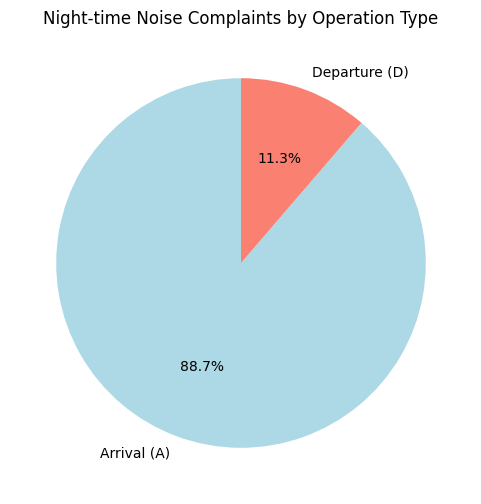

In [44]:
plt.figure(figsize=(6,6))
plt.pie(
    complaints_by_operation,
    labels=['Arrival (A)', 'Departure (D)'],
    autopct='%1.1f%%',
    colors=['lightblue','salmon'],
    startangle=90
)
plt.title("Night-time Noise Complaints by Operation Type")
plt.show()
